## *Casualty*

<img src="price_casual.webp" alt="casual" width="400">

*`Casualty`*

In the world of business, setting the **right price** for a product or service is a delicate balance. **It's not just about randomly picking a number;** it's about understanding how that **price** will impact consumer behavior and, ultimately, your bottom line. This is where casualty comes into play. In this notebook, we'll delve into the concept of casualty and explore why it's crucial for businesses to grasp this relationship when devising their **pricing strategies.**

Imagine you're running a lemonade stand on a scorching summer day. You're faced with a critical decision: How much should you charge for a cup of refreshing lemonade? Set the price too high, and you risk turning away potential customers who perceive it as too expensive. Set it too low, and you may attract a crowd but fail to cover your costs. This scenario perfectly illustrates the importance of casualty—the cause-and-effect relationship between price changes and consumer behavior.

Understanding casualty enables businesses to make informed decisions about pricing strategies. By analyzing how changes in **price influence** the demand for their products or services, businesses can strike the right balance between attracting customers and maximizing profits. 

In this notebook, we'll explore real-world examples and practical insights to illustrate the significance of casualty in pricing strategies and how businesses can leverage this understanding to achieve their goals. So, let's dive in and unravel the intricacies of casualty in pricing!

`packages`

In [1]:
# general
import psycopg2
import pandas as pd
from sqlalchemy import create_engine
import os, yaml, requests
import numpy as np

# econML

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.style.use('ggplot')

# warnings
import warnings
warnings.filterwarnings('ignore')

c:\users\migue\appdata\local\programs\python\python39\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (5.2.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


`functions`

In [2]:
def read_yaml_file(yaml_file):
    """ load yaml cofigurations """

    config = None
    try:
        with open(yaml_file, 'r') as f:
            config = yaml.safe_load(f)
    except:
        raise FileNotFoundError('Couldnt load the file')

    return config


def get_db_conn_post(creds_file):
    """ Get an authenticated psycopg db connection, given a credentials file"""
    creds = read_yaml_file(creds_file)['db']

    connection = psycopg2.connect(
        user=creds['user'],
        password=creds['pass'],
        host=creds['host'],
        port=creds['port'],
        database=creds['db']
    )

    return connection

`get data`

In [3]:
db_conn_post = get_db_conn_post("key_postgresql.yaml")

In [4]:
q = """
    select
            *
    from
            kaggle_data.price_optimization.data_gas_station;
"""

In [5]:
df_raw = pd.read_sql(sql = q, con = db_conn_post)
df_raw.head(3)

,date,day,month,year,product,hour,volume,transactions,avg_by_tkt,price,raining_days,weekday,is_weekend,holiday_name
0,2019-06-09,9,6,2019,diesel,10,47.416,2,23.708,21.09,26.1,7,1,normal day
1,2019-06-09,9,6,2019,diesel,16,100.000,1,100.000,21.09,26.1,7,1,normal day
2,2019-06-09,9,6,2019,diesel,19,9.483,1,9.483,21.09,26.1,7,1,normal day


**`adjust the dataset`**

In [6]:
# add holiday flag
df_raw['holiday_flag']=np.where(df_raw['holiday_name']!='normal day', 1, 0)

For the purpose of our analysis, we will consider that the COVID-19 pandemic began in March, and we will mark this as a significant event in our data.

In [7]:
df_raw['covid']=np.where(df_raw['date']>'2020-03-20', 1, 0)
df_raw.head(1)

,date,day,month,year,product,hour,volume,transactions,avg_by_tkt,price,raining_days,weekday,is_weekend,holiday_name,holiday_flag,covid
0,2019-06-09,9,6,2019,diesel,10,47.416,2,23.708,21.09,26.1,7,1,normal day,0,0


*create a copy form the original data*

In [8]:
df=df_raw.copy()

In [9]:
cols = ['date', 'hour', 'volume', 'price', 'raining_days', 'weekday', 'is_weekend', 'holiday_flag', 'covid']
condition=df['product']=='regular'
data=df[cols][condition].\
            groupby(by=['date', 'weekday', 'is_weekend', 'hour', 'raining_days','holiday_flag', 'covid'], as_index=False).\
            agg({'volume':'sum', 'price':'mean'}).\
            drop(columns='date', inplace=False)
print(data.shape)
data.head(1)

(8379, 8)


,weekday,is_weekend,hour,raining_days,holiday_flag,covid,volume,price
0,7,1,6,26.1,0,0,84.356,19.59


*`EconML`*, short for Economic Machine Learning, is a game-changer in economic analysis. By combining economic principles with the computational muscle of machine learning, it helps us understand how different factors affect sales. 

This approach allows researchers and policymakers to dig deep into complex data, revealing cause-and-effect relationships in the real world. With EconML, policymakers can evaluate policies more accurately, estimate treatment effects better, and explore "what-if" scenarios more effectively. By bridging economics and machine learning, EconML is set to transform economic analysis and improve decision-making processes.

In [10]:
# Utilities
import urllib.request

# generic ML imports
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# EconML imports
from econml.dml import LinearDML, CausalForestDML
from econml.cate_interpreter import SingleTreeCateInterpreter, SingleTreePolicyInterpreter

In [11]:
train, test = train_test_split(data, test_size=0.2, random_state=42)
train.head(1)

,weekday,is_weekend,hour,raining_days,holiday_flag,covid,volume,price
3139,2,0,5,7.6,0,0,33.129,19.03


In [12]:
# ***************************************************************************
# ***************************************************************************
# train
train_Y=train['volume']
train_T=train['price']
train_X=train[['weekday', 'is_weekend', 'raining_days', 'holiday_flag']]
train_W=train[['hour', 'covid']]
# ***************************************************************************
# ***************************************************************************
# ***************************************************************************
# ***************************************************************************
# test
test_Y=test['volume']
test_T=test['price']
test_X=test[['weekday', 'is_weekend', 'raining_days', 'holiday_flag']]
test_W=test[['hour', 'covid']]

For our initial approach, we employ the `LinearDML` estimator. Since we lack specific assumptions about these models, we opt for a versatile gradient boosting estimator to glean insights into the expected price and demand from our dataset.

In [13]:
rfr=RandomForestRegressor(n_estimators=500, min_samples_split=3, max_depth=20, n_jobs=-1, random_state=42)
gb=GradientBoostingRegressor()
lr=LinearRegression()

# Train EconML model
est = LinearDML(
        model_y=gb,
        model_t=gb,
        featurizer=PolynomialFeatures(degree=1, include_bias=False),
)
est.fit(train_Y, 
        train_T, 
        X=train_X, 
        W=train_W, 
        inference="statsmodels")

# Get treatment effect and its confidence interval
te_pred = est.effect(test_X)
te_pred_interval = est.effect_interval(test_X)

In [14]:
est.summary()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
weekday,12.818,4.846,2.645,0.008,3.32,22.317
is_weekend,-71.024,20.529,-3.46,0.001,-111.261,-30.788
raining_days,0.712,0.54,1.317,0.188,-0.347,1.771
holiday_flag,186.284,53.906,3.456,0.001,80.629,291.938
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,-37.099,14.342,-2.587,0.01,-65.209,-8.989


From the table above, we notice several important patterns:

- Weekday plays a significant role in sales. 
- Typically, sales increase on weekdays and decrease on weekends. 
- During holidays, sales tend to rise as many customers travel and fill up their tanks before leaving the city.
- However, rainy days and holidays may not always directly impact sales. Their effects on sales are not consistent.
- Notably, **price** has a **consistent negative effect on sales,** meaning that higher prices lead to lower sales. This relationship is statistically significant, indicating it's not just random chance but a causal effect on sales.

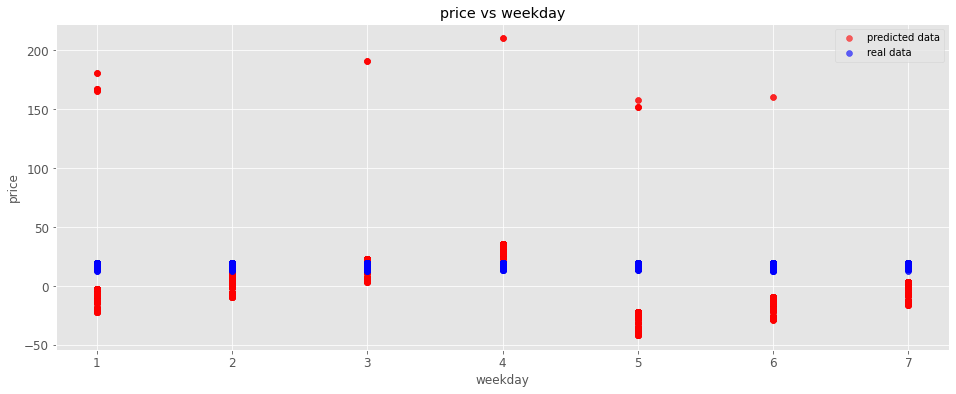

In [15]:
# Compare the estimate and the truth
plt.figure(figsize=(16, 6))
plt.scatter(test_X['weekday'].values.flatten(), te_pred, color='r', alpha=0.6, label="predicted data")
plt.scatter(test_X['weekday'].values.flatten(), test_T, color='b', alpha=0.6, label="real data")

plt.xlabel("weekday")
plt.ylabel("price")
plt.title("price vs weekday")
plt.legend(loc="upper right")
plt.show()

From the chart, it's evident that although some features appear to have a causal relationship, the forecast of the treatment effect lacks accuracy. To address this issue, we employ a causal forest model to better capture the potential nonlinear relationships between the features and the treatment effect.

In [16]:
# Train EconML model
est_fr = CausalForestDML(
                model_y=rfr, 
                model_t=rfr
)

est_fr.fit(train_Y, 
           train_T, 
           X=train_X, 
           W=train_W, 
           inference="blb")

# Get treatment effect and its confidence interval
te_pred_fr = est_fr.effect(test_X)
te_pred_fr_interval = est_fr.effect_interval(test_X)

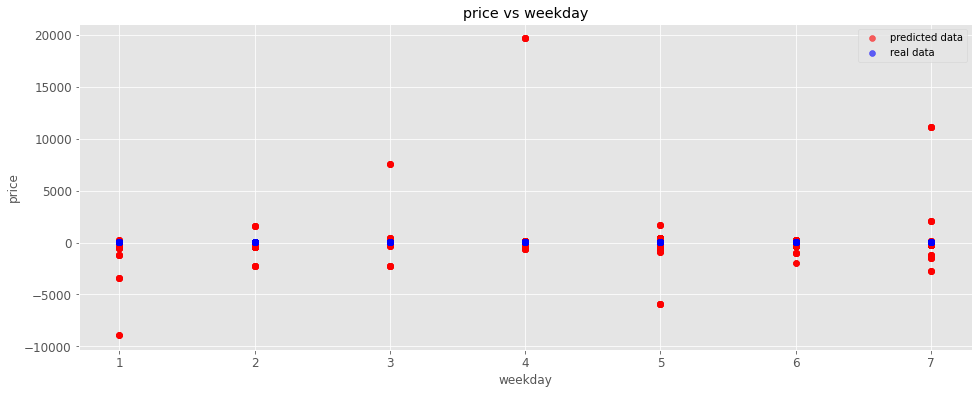

In [17]:
# Compare the estimate and the truth
plt.figure(figsize=(16, 6))
plt.scatter(test_X['weekday'].values.flatten(), te_pred_fr, color='r', alpha=0.6, label="predicted data")
plt.scatter(test_X['weekday'].values.flatten(), test_T, color='b', alpha=0.6, label="real data")

plt.xlabel("weekday")
plt.ylabel("price")
plt.title("price vs weekday")
plt.legend(loc="upper right")
plt.show()

The causal forest model yields unsatisfactory predictions, prompting us to revisit our initial linear model. It's crucial to highlight that the causal forest excels in capturing the nonlinear relationships between variables and the output.

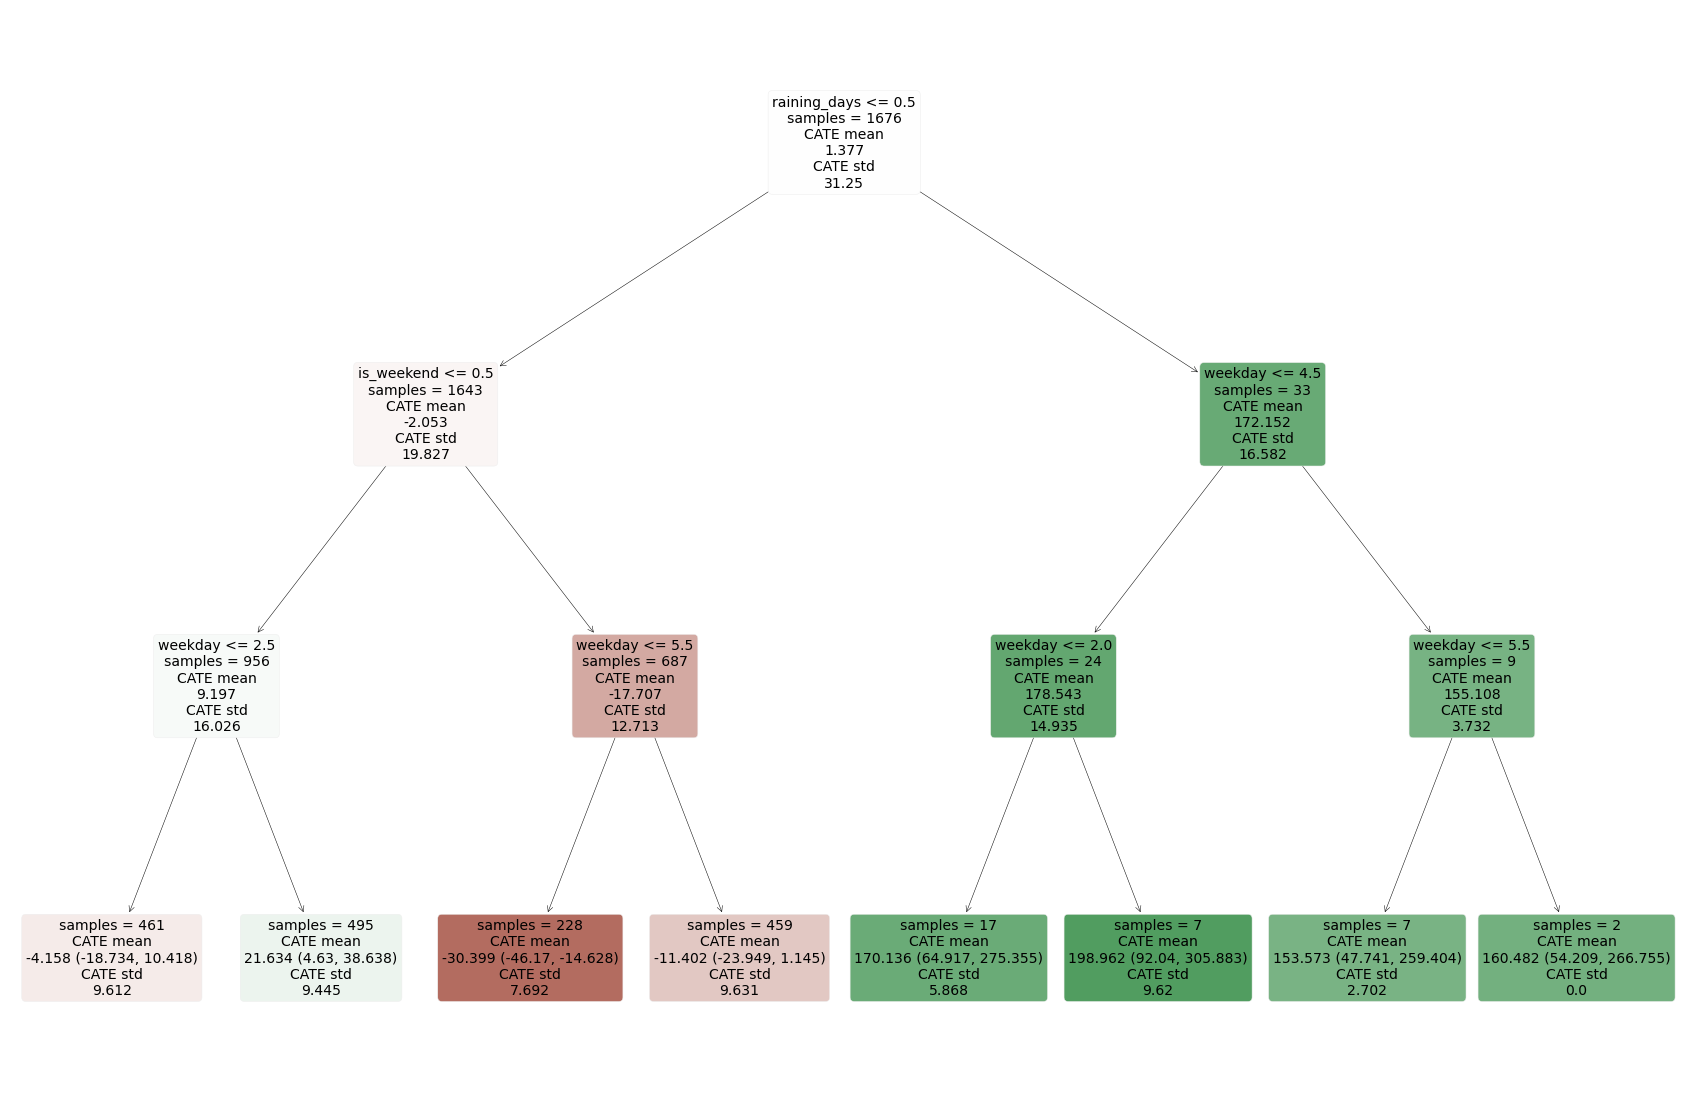

In [18]:
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=3, min_samples_leaf=2)
intrp.interpret(est, test_X)
plt.figure(figsize=(30, 20))
intrp.plot(feature_names=test.columns, fontsize=14)

In the depicted tree, the initial data split is based on rainy days. Subsequently, the pivotal factor distinguishing branches is whether it's a weekday or a weekend. Notably, the mean CATE demonstrates an increasing trend corresponding to higher day numbers.

Utilizing a policy interpreter that factors in treatment costs and effects to discern profitable customer targeting strategies, we observe the following patterns: In many instances, reducing prices and adopting a lower pricing strategy is advisable. However, when the count of rainy days is less than or equal to 10.55, it's recommended to raise prices. Additionally, the analysis underscores the significance of other causal variables such as weekday and holiday occurrences. For instance, holidays, estimated to have a point estimate of 186, suggest a price increase strategy during those days.

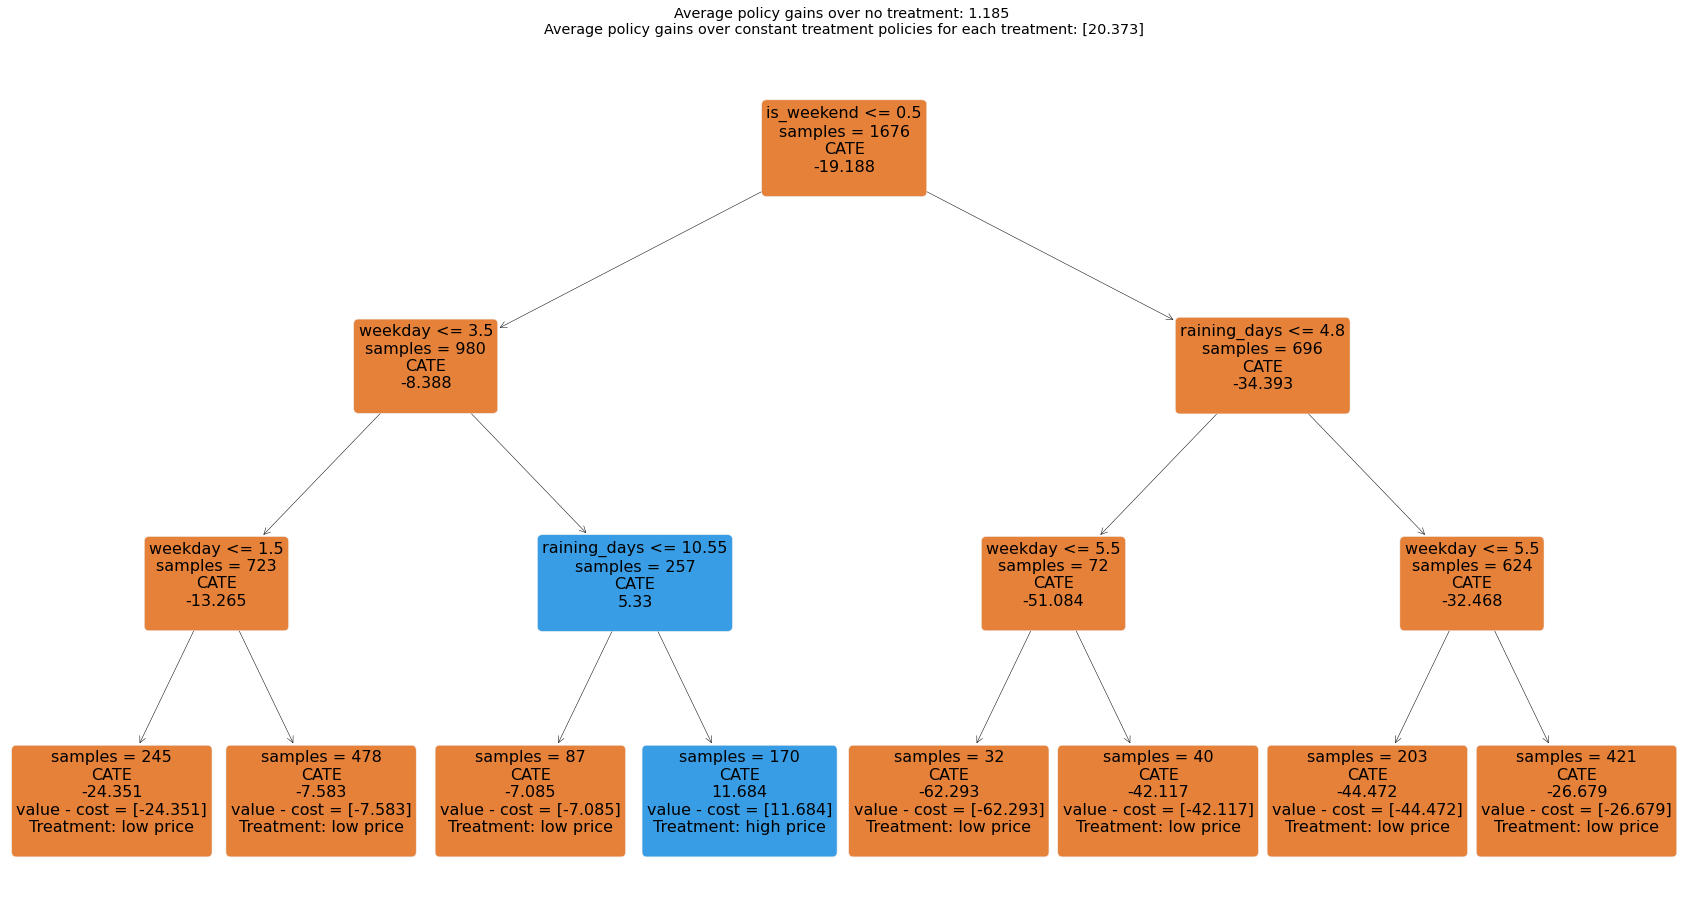

In [21]:
intrp = SingleTreePolicyInterpreter(risk_level=0.05, max_depth=3, min_samples_leaf=2)
intrp.interpret(est, test_X)
plt.figure(figsize=(30, 16))
intrp.plot(feature_names=test_X.columns, treatment_names=["low price", "high price"], fontsize=16)